In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import HTML
display(HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {padding: 0; border: 0;}</style>"));

In [3]:
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
from scipy import stats
from glob import glob
from PIL import Image

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

import io, os, sys
import torch
import pickle
%matplotlib inline
sys.path.append('..')

In [4]:
brain_data_dir = '../neural_data/'
output_dir = 'taskonomy_results/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [5]:
brain_rdms = pickle.load(open(brain_data_dir + 'rdms_reliable.pkl', 'rb'))
noise_ceiling = pd.read_csv(brain_data_dir + 'rdms_splithalf.csv')

# Taskonomy Analysis (Latent Space)

In [6]:
model_rdms = pickle.load(open("taskonomy_zspace_rdms.pkl", "rb"))

### Representational Similarity Analysis (RSA)

In [7]:
from scipy.stats import pearsonr, spearmanr

output_file = output_dir + 'taskonomy_rsa_zspace.csv'
if os.path.exists(output_file):
    rsa = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    rsa_dict_list = []
    for model in tqdm(model_rdms.keys()):
        model_rdm = model_rdms[model]
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                model_rdm_triu = model_rdm[np.triu_indices(model_rdm.shape[0], k=1)]
                brain_rdm_triu = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
                mouse_model_corr = pearsonr((brain_rdm_triu).flatten(), (model_rdm_triu).flatten())[0]
                rsa_dict_list.append({'model': model, 'area': area, 'layer': layer, 'rsa_r': mouse_model_corr})

    rsa = pd.DataFrame(rsa_dict_list)
    rsa.to_csv(output_file, index = None)

In [8]:
rsa['neural_site'] = rsa.apply(lambda x: x['area'] + '-' + x['layer'], 1)

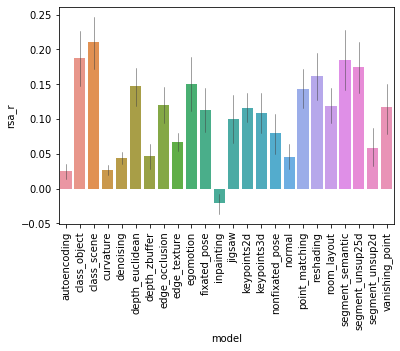

In [9]:
p=sns.barplot('model', 'rsa_r', data = rsa, errwidth=0.5)
plt.setp(p.get_xticklabels(), rotation=90);

### Non-Negative Least Squares Linear Regression Analysis (NNLSA)

In [10]:
from nnls_regression import *

In [11]:
output_file = output_dir + 'taskonomy_nnlsa_zspace.csv'
if os.path.exists(output_file):
    nnlsa = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    nnls_dict_list = []
    for model in tqdm(model_rdms.keys()):
        model_rdm = model_rdms[model][:,:,np.newaxis]
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                nnls = kfold_nonnegative_regression(brain_rdm, model_rdm, n_splits=6, n_repeats=10)
                nnls_dict_list.append({'model': model, 'area': area, 'layer': layer, 'nnls_r': nnls[0]})

    nnlsa = pd.DataFrame(nnls_dict_list)
    nnlsa.to_csv(output_file, index=None)

In [12]:
nnlsa['neural_site'] = nnlsa.apply(lambda x: x['area']+'-'+x['layer'], 1)

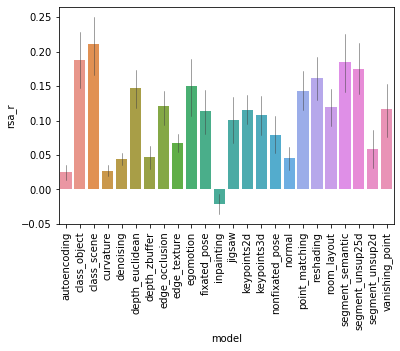

In [13]:
p=sns.barplot('model', 'rsa_r', data = rsa, errwidth=0.5)
plt.setp(p.get_xticklabels(), rotation=90);

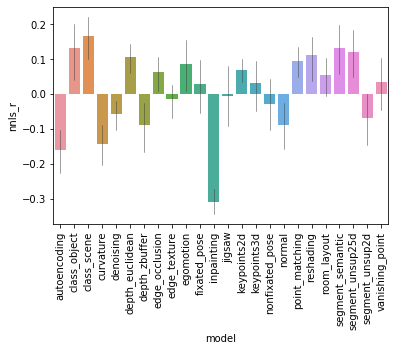

In [14]:
p=sns.barplot('model', 'nnls_r', data = nnlsa, errwidth=0.5)
plt.setp(p.get_xticklabels(), rotation=90);

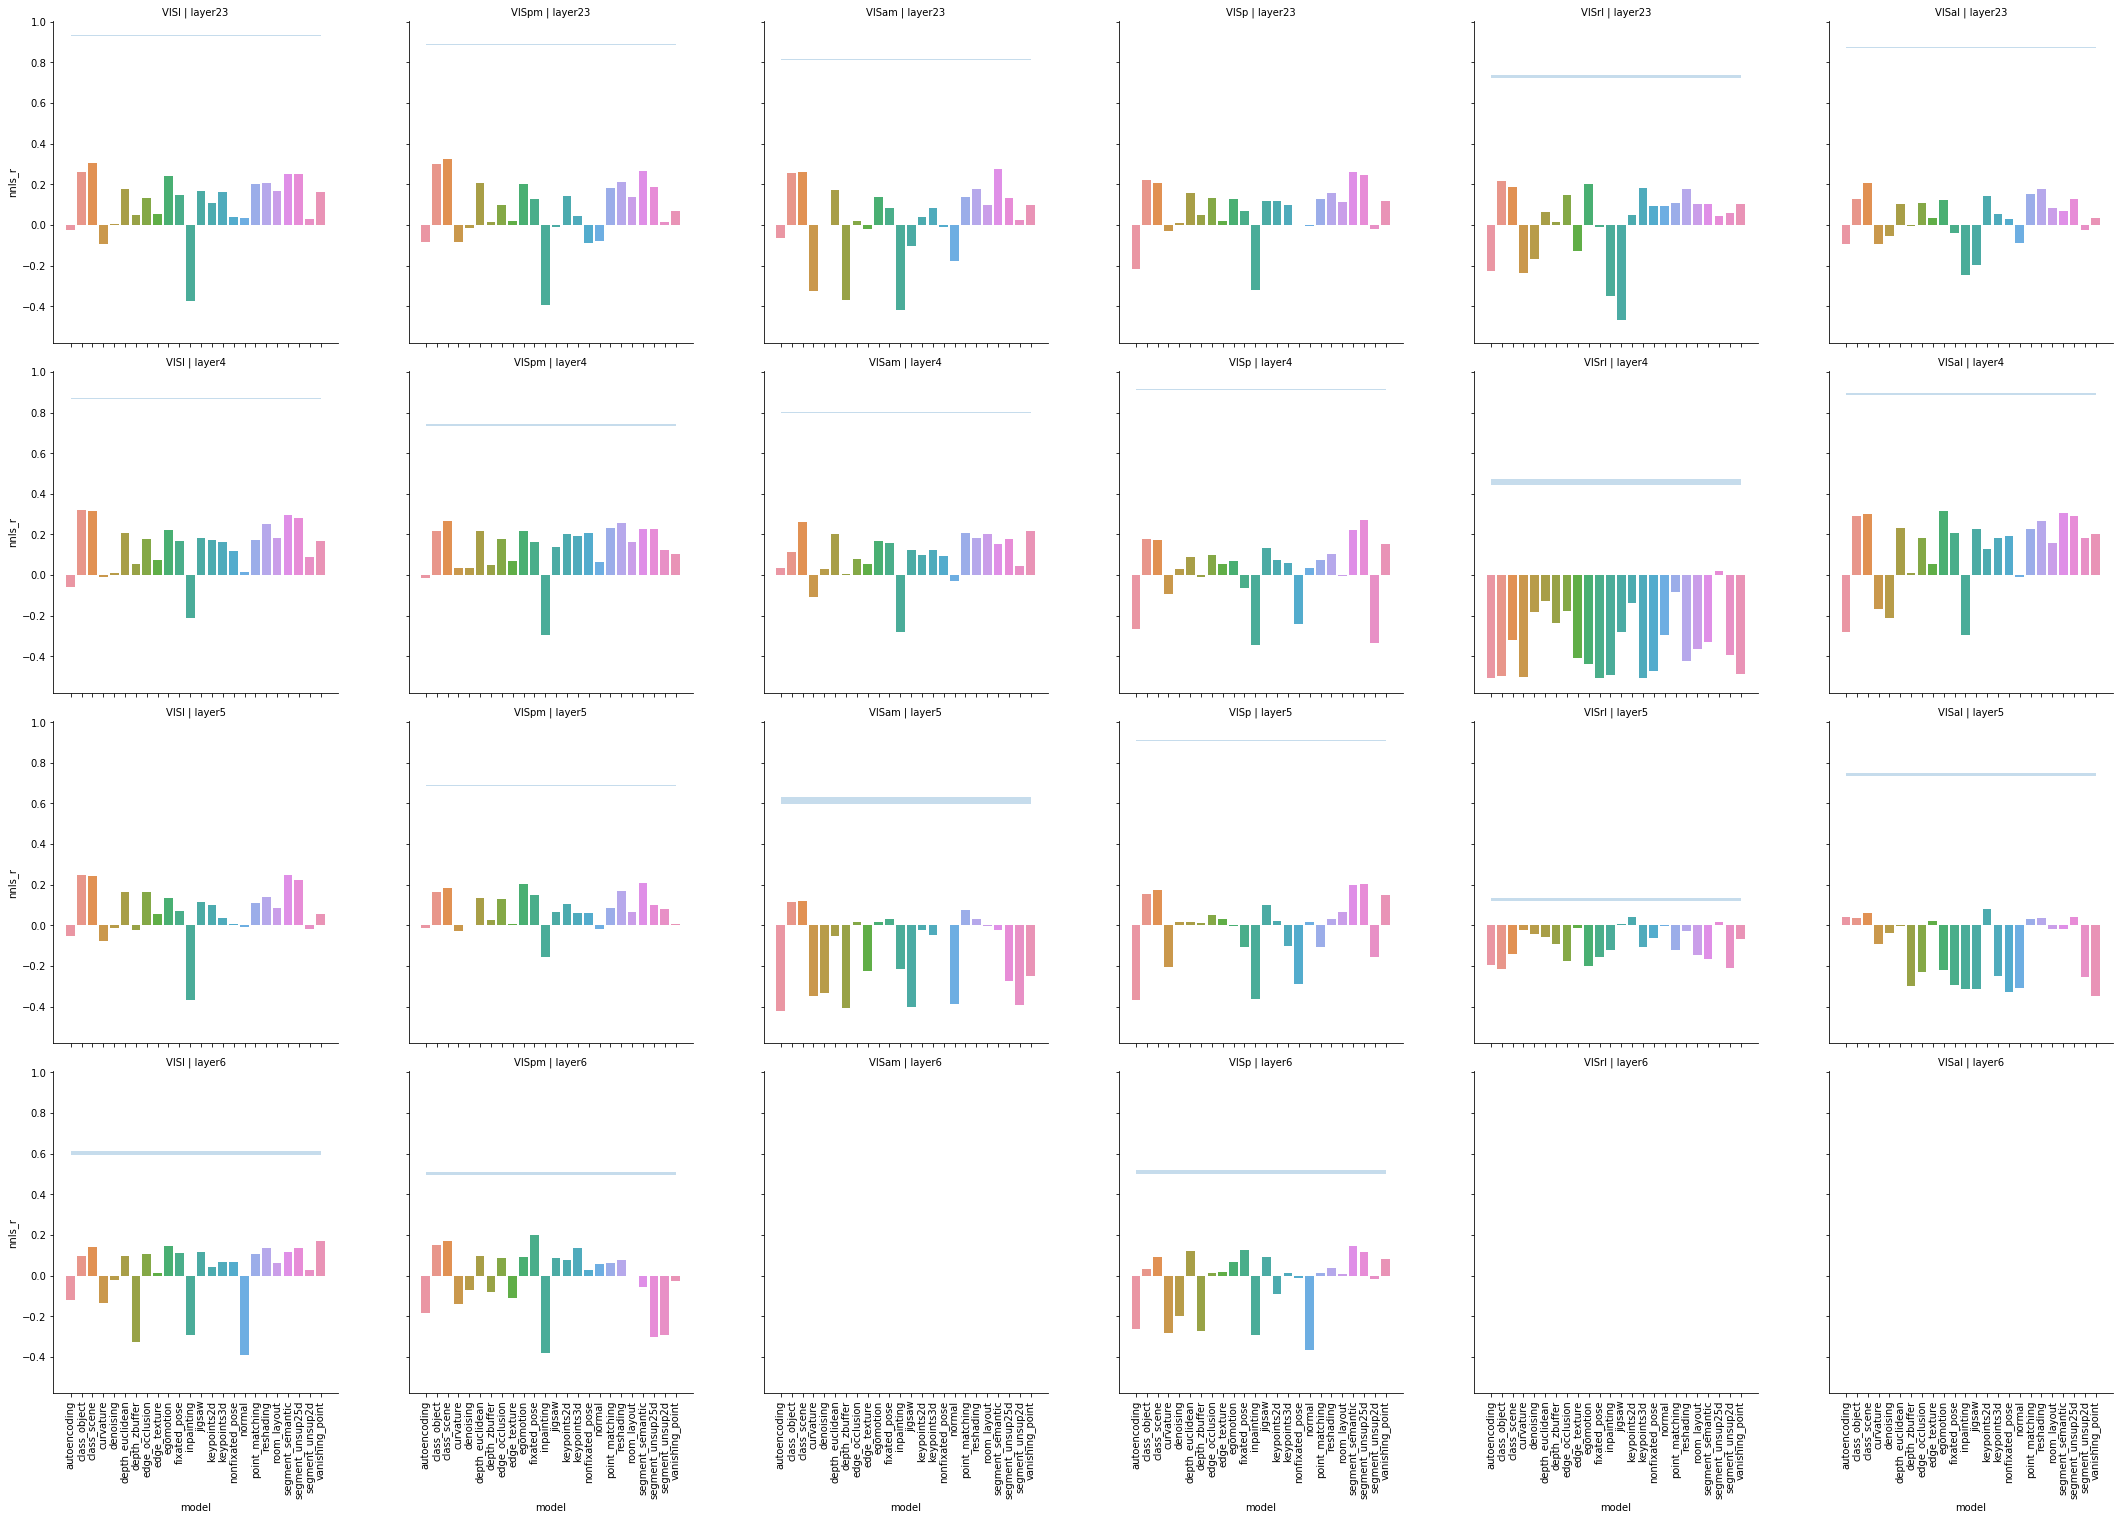

In [15]:
g=sns.catplot(x='model', y='nnls_r', kind='bar',col = 'area', row = 'layer', errwidth=0.75, data=nnlsa)
g.set_titles(row_template = '{col_name}', col_template = '{row_name}')

for ax in g.axes.flat:
    ax_title = ax.get_title().split(' | ')
    plt.setp(ax.get_xticklabels(), rotation=90)
    if ((noise_ceiling['area'] == ax_title[0]) & (noise_ceiling['layer'] == ax_title[1])).any():
        ax_ceiling = noise_ceiling.loc[(noise_ceiling['area'] == ax_title[0]) & (noise_ceiling['layer'] == ax_title[1]),:]
        lower = (ax_ceiling['mean'] - ax_ceiling['sem']).values[0]
        upper = (ax_ceiling['mean'] + ax_ceiling['sem']).values[0]
        ax.fill_between(ax.get_xticks(), lower, upper, alpha = 0.25)

In [16]:
nnlsa.groupby(['model']).mean().to_dict()['nnls_r']

{'autoencoding': -0.16134610049532416,
 'class_object': 0.13253038802708442,
 'class_scene': 0.1677490165186689,
 'curvature': -0.14466839776410406,
 'denoising': -0.05770211091093516,
 'depth_euclidean': 0.1053206596472603,
 'depth_zbuffer': -0.08775930086927912,
 'edge_occlusion': 0.06332476430477932,
 'edge_texture': -0.015442850900695151,
 'egomotion': 0.08637076027849473,
 'fixated_pose': 0.03012874493447443,
 'inpainting': -0.3104604334708866,
 'jigsaw': -0.00493917958721599,
 'keypoints2d': 0.07036622701291947,
 'keypoints3d': 0.030331456832099417,
 'nonfixated_pose': -0.027285048582692196,
 'normal': -0.08828071979373785,
 'point_matching': 0.09489039693492621,
 'reshading': 0.11305038337763017,
 'room_layout': 0.055128879855847676,
 'segment_semantic': 0.13103804042586978,
 'segment_unsup25d': 0.1206251313583519,
 'segment_unsup2d': -0.06884223983935092,
 'vanishing_point': 0.033459624965958515}

In [19]:
task_category_palette = {'Other':'#525353','2D':'#3976AF','3D':'#509D3E','Geometric':'#C63A32','Semantic':'#8A67B3'}
task_df = pd.read_csv('../model_opts/task_typology.csv')
nnlsa_plus_task = nnlsa.merge(task_df, on='model')

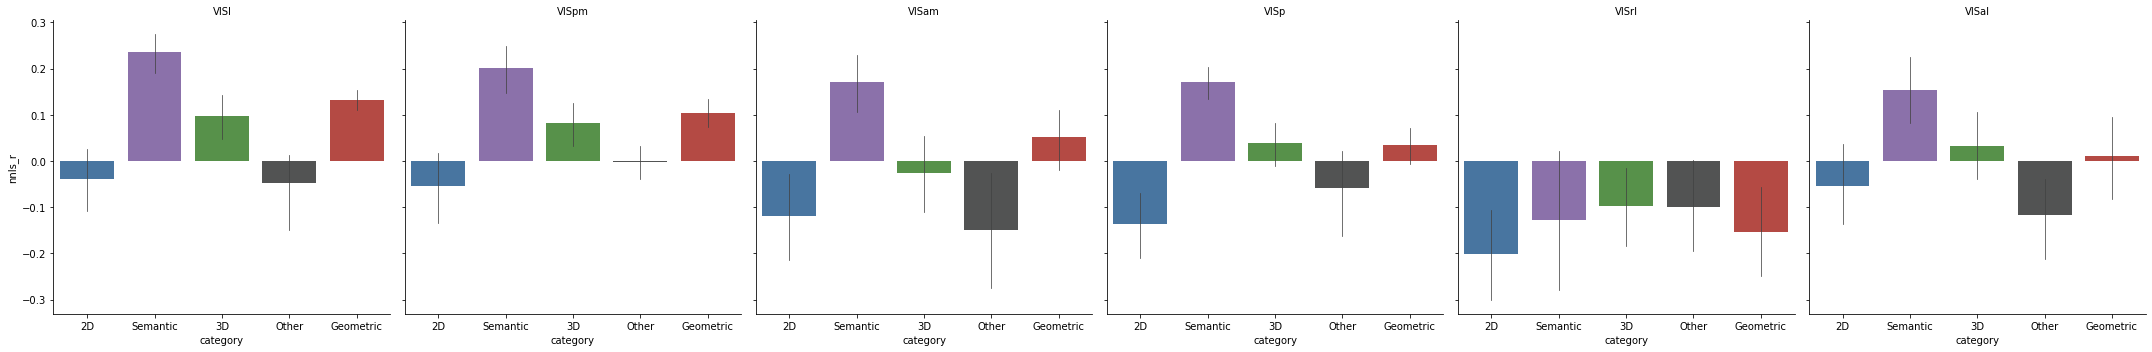

In [20]:
g=sns.catplot(x='category', y='nnls_r', kind='bar', col='area', palette=task_category_palette, errwidth=0.75, data=nnlsa_plus_task)
g.set_titles(col_template = '{col_name}');

In [21]:
nnlsa.anova(dv='nnls_r', between=['model','neural_site']).round(5)

,Source,SS,DF,MS,np2
0,model,6.25055,23,0.27176,1.0
1,neural_site,6.18228,20,0.30911,1.0
2,model * neural_site,4.64543,460,0.01010,1.0
3,Residual,0.00000,0,NaN,NaN


In [22]:
nnlsa_plus_task.anova(dv='nnls_r', between=['category', 'neural_site']).round(5)

,Source,SS,DF,MS,F,p-unc,np2
0,category,2.78960,4.0,0.69740,41.53631,0.00000,0.29399
1,neural_site,6.18228,20.0,0.30911,18.41043,0.00000,0.47993
2,category * neural_site,1.40710,80.0,0.01759,1.04757,0.37914,0.17358
3,Residual,6.69927,399.0,0.01679,NaN,NaN,NaN


In [23]:
nnlsa_plus_task.pairwise_ttests(dv='nnls_r', between='area', padjust='bonf').round(5)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,area,VISl,VISpm,False,True,0.78448,190.00000,two-sided,0.43374,1.00000,bonf,0.209,0.11278
1,area,VISl,VISam,False,True,3.37950,126.94506,two-sided,0.00097,0.01448,bonf,29.54,0.54584
2,area,VISl,VISp,False,True,3.38838,190.00000,two-sided,0.00085,0.01282,bonf,30.035,0.48714
3,area,VISl,VISrl,False,True,7.80239,121.08756,two-sided,0.00000,0.00000,bonf,9.745e+09,1.27111
4,area,VISl,VISal,False,True,2.77977,130.97074,two-sided,0.00624,0.09362,bonf,5.706,0.44635
5,area,VISpm,VISam,False,True,2.80268,124.62367,two-sided,0.00588,0.08818,bonf,6.043,0.45421
6,area,VISpm,VISp,False,True,2.67821,190.00000,two-sided,0.00805,0.12075,bonf,4.293,0.38504
7,area,VISpm,VISrl,False,True,7.28186,118.90531,two-sided,0.00000,0.00000,bonf,5.7e+08,1.19019
8,area,VISpm,VISal,False,True,2.18097,128.58066,two-sided,0.03100,0.46507,bonf,1.492,0.35142
9,area,VISam,VISp,False,True,-0.62907,134.84378,two-sided,0.53037,1.00000,bonf,0.202,-0.10044


In [24]:
nnlsa_plus_task.pairwise_ttests(dv='nnls_r', between='category', padjust='bonf').round(5)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,category,2D,Semantic,False,True,-8.74477,138.77953,two-sided,0.00000,0.00000,bonf,2.076e+12,-1.36036
1,category,2D,3D,False,True,-5.57004,215.27772,two-sided,0.00000,0.00000,bonf,1.729e+05,-0.71717
2,category,2D,Other,False,True,-0.88828,101.66238,two-sided,0.37649,1.00000,bonf,0.278,-0.14201
3,category,2D,Geometric,False,True,-6.01132,214.41001,two-sided,0.00000,0.00000,bonf,1.535e+06,-0.77477
4,category,Semantic,3D,False,True,4.54238,118.93009,two-sided,0.00001,0.00013,bonf,1755.16,0.67761
5,category,Semantic,Other,False,True,7.33823,99.58108,two-sided,0.00000,0.00000,bonf,1.394e+08,1.38765
6,category,Semantic,Geometric,False,True,4.16957,118.27203,two-sided,0.00006,0.00058,bonf,424.64,0.62351
7,category,3D,Other,False,True,4.06958,82.62076,two-sided,0.00011,0.00107,bonf,293.373,0.62148
8,category,3D,Geometric,False,True,-0.48778,292.00000,two-sided,0.62607,1.00000,bonf,0.144,-0.05675
9,category,Other,Geometric,False,True,-4.46450,82.10536,two-sided,0.00003,0.00025,bonf,1249.881,-0.68401


In [25]:
# (nnlsa_plus_task.pairwise_ttests(dv='nnls_r', between=['area', 'category'], padjust='bonf', effsize='cohen').round(7)
#  .to_csv('taskonomy_nnlsa_category_anova.csv', index=None))
nnlsa_plus_task.pairwise_ttests(dv='nnls_r', between=['category', 'area'], padjust='bonf', effsize='cohen').round(5)

,Contrast,category,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,category,-,2D,Semantic,False,True,-8.74477,138.77953,two-sided,0.00000,0.00000,bonf,2.076e+12,-1.36654
1,category,-,2D,3D,False,True,-5.57004,215.27772,two-sided,0.00000,0.00000,bonf,1.729e+05,-0.71934
2,category,-,2D,Other,False,True,-0.88828,101.66238,two-sided,0.37649,1.00000,bonf,0.278,-0.14275
3,category,-,2D,Geometric,False,True,-6.01132,214.41001,two-sided,0.00000,0.00000,bonf,1.535e+06,-0.77711
4,category,-,Semantic,3D,False,True,4.54238,118.93009,two-sided,0.00001,0.00013,bonf,1755.16,0.68007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,category * area,Geometric,VISam,VISrl,False,True,3.45361,40.00000,two-sided,0.00132,0.09913,bonf,24.79,1.06581
96,category * area,Geometric,VISam,VISal,False,True,0.72621,40.00000,two-sided,0.47194,1.00000,bonf,0.374,0.22411
97,category * area,Geometric,VISp,VISrl,False,True,3.50816,27.20238,two-sided,0.00159,0.11908,bonf,30.968,1.10785
98,category * area,Geometric,VISp,VISal,False,True,0.48200,28.29442,two-sided,0.63351,1.00000,bonf,0.316,0.15115


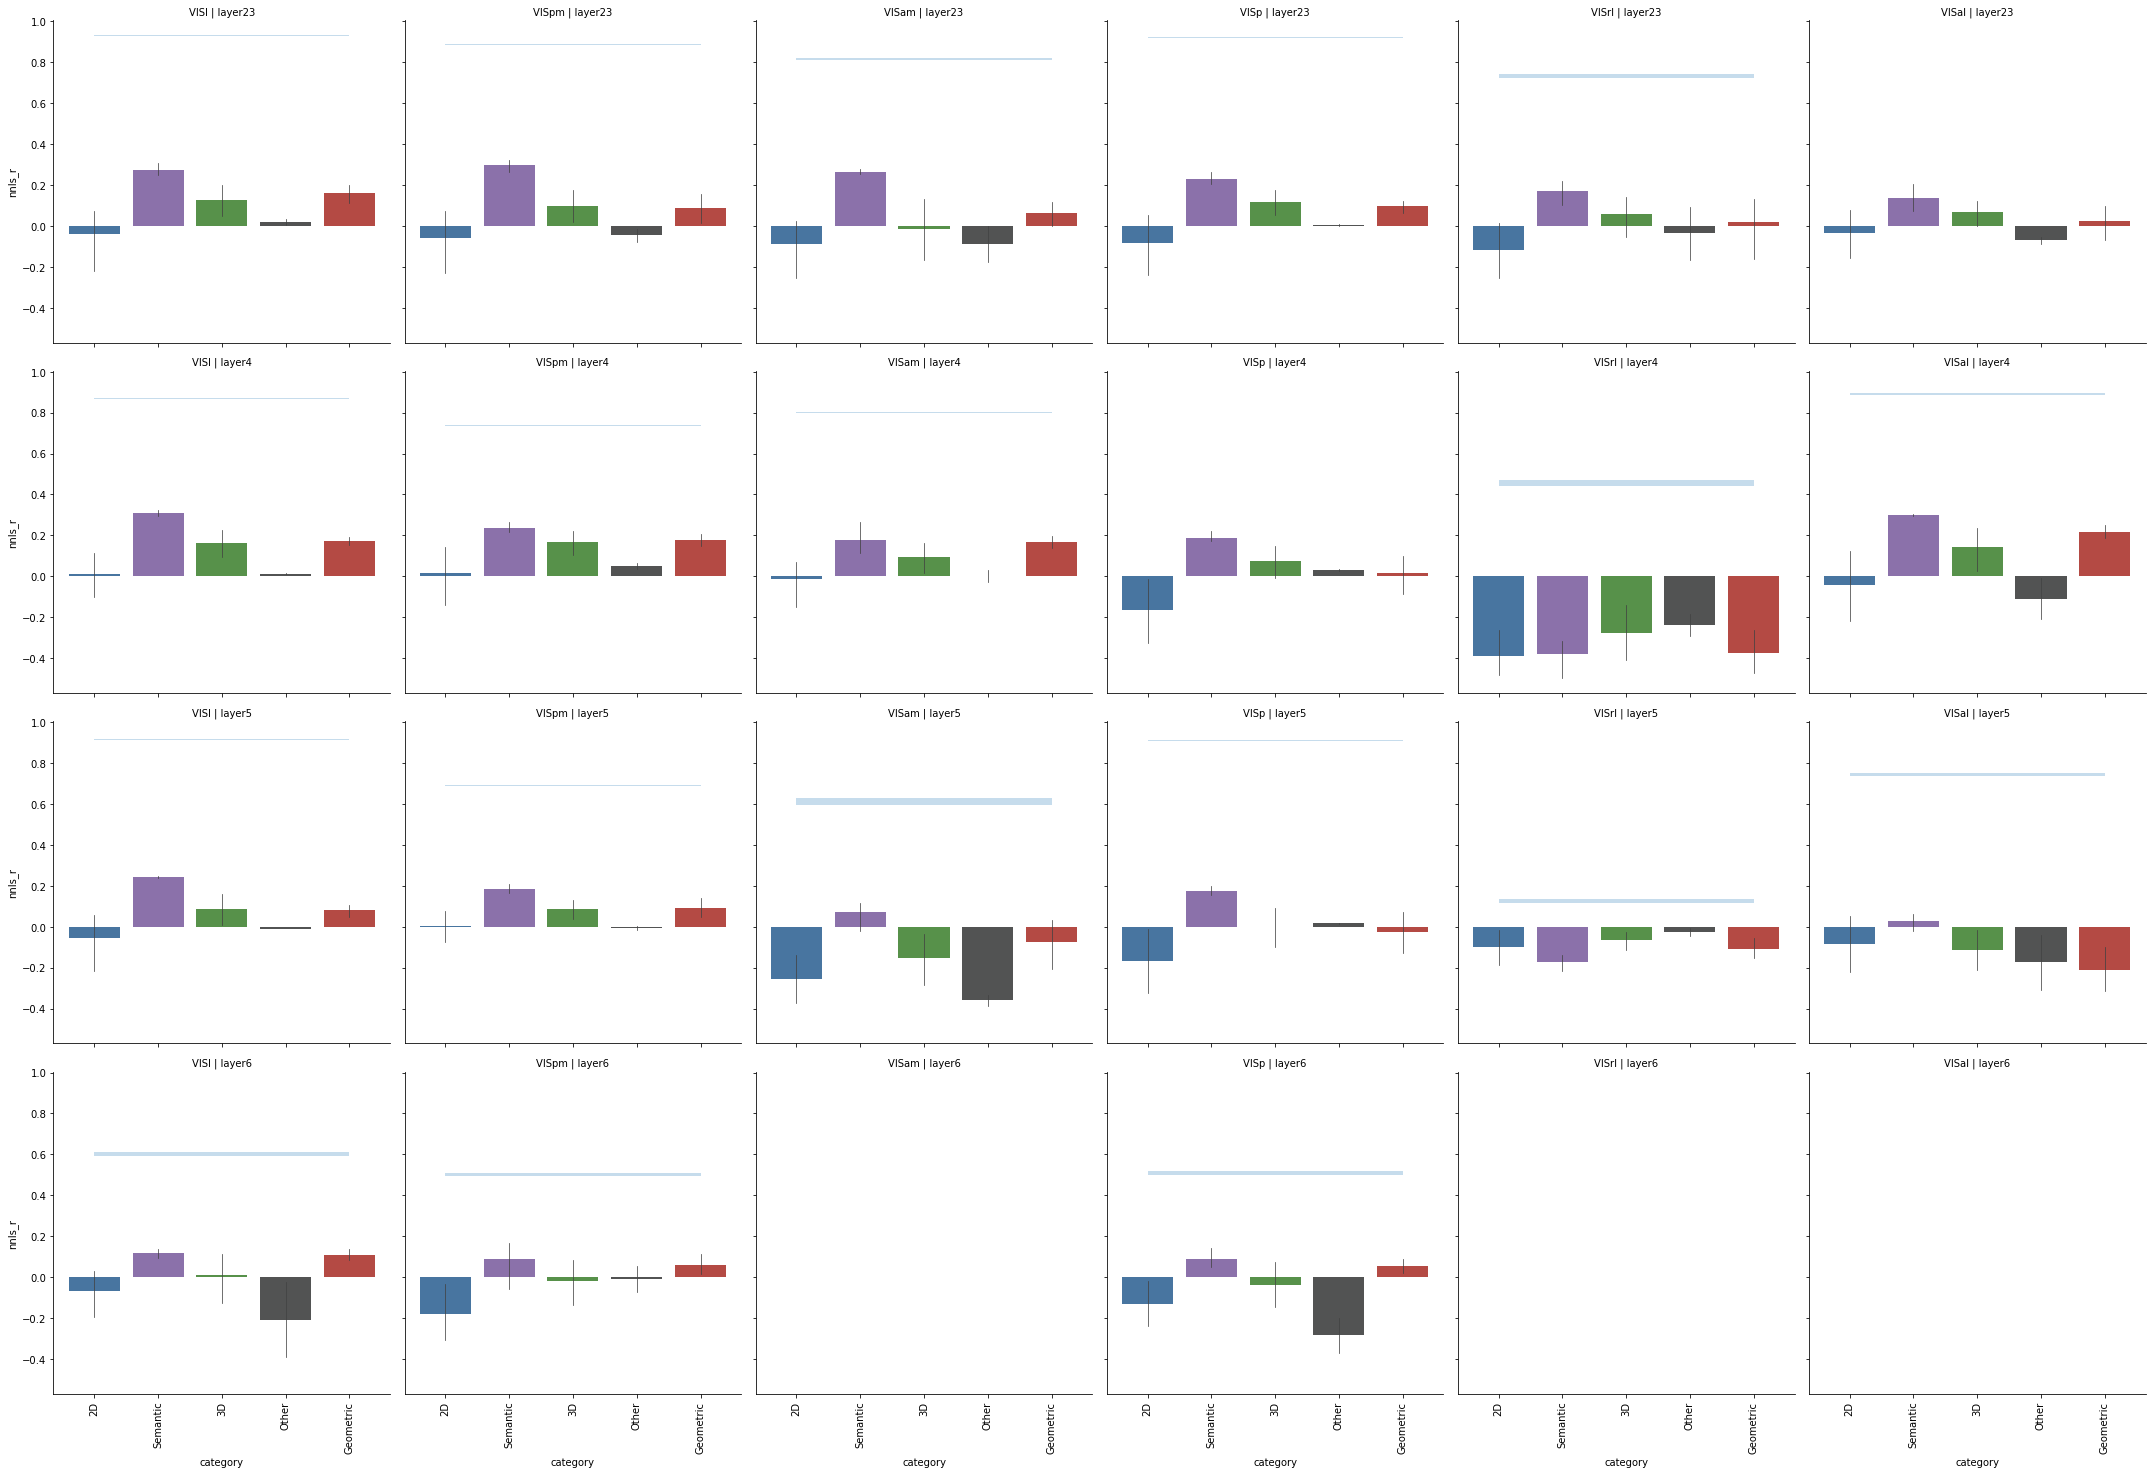

In [26]:
g=sns.catplot(x='category', y='nnls_r', kind='bar', col = 'area', row = 'layer', errwidth=0.75, 
              palette=task_category_palette, data=nnlsa_plus_task)
g.set_titles(row_template = '{col_name}', col_template = '{row_name}')

for ax in g.axes.flat:
    ax_title = ax.get_title().split(' | ')
    plt.setp(ax.get_xticklabels(), rotation=90)
    if ((noise_ceiling['area'] == ax_title[0]) & (noise_ceiling['layer'] == ax_title[1])).any():
        ax_ceiling = noise_ceiling.loc[(noise_ceiling['area'] == ax_title[0]) & (noise_ceiling['layer'] == ax_title[1]),:]
        lower = (ax_ceiling['mean'] - ax_ceiling['sem']).values[0]
        upper = (ax_ceiling['mean'] + ax_ceiling['sem']).values[0]
        ax.fill_between(ax.get_xticks(), lower, upper, alpha = 0.25)

### Clustered NNLSA Analysis

In [ ]:
task_df_subset = task_df[task_df['model'].isin(list(model_rdms.keys()))]
category_rdm_dict = {}
categories = ['2D', '3D', 'Geometric', 'Semantic', 'Unspecified']

for category in categories:
    category_task_list = task_df_subset[task_df_subset['category'] == category]['model'].to_list()
    category_rdm_list = []
    for task in category_task_list:
        category_rdm_list.append(model_rdms[task])
    category_rdm_dict[category] = {'tasks': category_task_list, 'rdms': np.stack(category_rdm_list, 2)}

In [ ]:
output_file = 'taskonomy_nnlsa_cluster.csv'
if os.path.exists(output_file):
    nnlsa_cluster = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    nnls_dict_list = []
    for category in tqdm(category_rdm_dict.keys()):
        category_rdms = category_rdm_dict[category]['rdms']
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                nnls = kfold_cross_validate_nnls(brain_rdm, category_rdms, n_splits=6, n_repeats=10)
                nnls_dict_list.append({'category': category, 'area': area, 'layer': layer, 'nnls_r': nnls[0]})

    nnlsa_cluster = pd.DataFrame(nnls_dict_list)
    nnlsa_cluster.to_csv(output_file, index=None)

In [ ]:
p=sns.barplot('category', 'nnls_r', data=nnlsa_cluster, errwidth=0.5, palette=task_category_palette)
plt.setp(p.get_xticklabels(), rotation=90);

In [ ]:
g=sns.catplot(x='category', y='nnls_r', kind='bar', col='area', palette=task_category_palette, errwidth=0.75, data=nnlsa_cluster)
g.set_titles(col_template = '{col_name}');

In [ ]:
nnlsa_cluster['neural_site'] = rsa.apply(lambda x: x['area'] + '-' + x['layer'], 1)

In [ ]:
nnlsa_cluster.anova(dv='nnls_r', between=['category', 'area']).round(5)

In [ ]:
nnlsa_cluster.pairwise_ttests(dv='nnls_r', between='category', padjust='bonf', effsize = 'cohen')

In [ ]:
# (nnlsa_cluster.pairwise_ttests(dv='nnls_r', between=['area', 'category'], padjust='bonf', effsize='cohen')
#  .to_csv('taskonomy_nnlsa_cluster_anova.csv', index=None))
nnlsa_cluster.pairwise_ttests(dv='nnls_r', between=['area', 'category'], padjust='bonf', effsize='cohen')

# Taskonomy Analysis (All Layers)

In [ ]:
model_paths = glob('models/*.pth')
model_names = sorted(['_'.join(model_path.split('.')[0].split('_')[:-1]) for model_path in os.listdir('models') 
                          if 'encoder' in model_path])

all_model_rdms = {}
source_dir = 'task_rdms/'
for model_name in tqdm(model_names):
    if os.path.exists(os.path.join(source_dir, model_name + '_rdms.pkl')):
        all_model_rdms[model_name] = pickle.load(open(os.path.join(source_dir, model_name + '_rdms.pkl'), 'rb'))

### Representational Similarity Analysis (RSA)

In [ ]:
from scipy.stats import pearsonr, spearmanr

output_file = output_dir + 'taskonomy_rsa_bylayer.csv'
if os.path.exists(output_file):
    rsa = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    rsa_dict_list = []
    for model in tqdm(all_model_rdms.keys()):
        model_rdms = all_model_rdms[model]
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                for model_layer_index, model_layer in enumerate(model_rdms.keys()):
                    model_rdm = model_rdms[model_layer]
                    model_rdm_triu = model_rdm[np.triu_indices(model_rdm.shape[0], k=1)]
                    brain_rdm_triu = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
                    mouse_model_corr = pearsonr((brain_rdm_triu).flatten(), (model_rdm_triu).flatten())[0]
                    rsa_dict_list.append({'model': model, 'model_layer': model_layer, 
                                          'model_layer_index': model_layer_index,
                                          'model_layer_relative': model_layer_index / len(model_rdms.keys()),
                                          'area': area, 'layer': layer, 'rsa_r': mouse_model_corr})

    rsa = pd.DataFrame(rsa_dict_list)
    rsa.to_csv(output_file, index = None)

In [ ]:
rsa['neural_site'] = rsa.apply(lambda x: x['area'] + '-' + x['layer'], 1)

In [ ]:
model_results = rsa.groupby(['model'])['rsa_r'].mean().reset_index()#.sort_values('rsa_r', ascending=False)
p=sns.barplot('model', 'rsa_r', data = rsa, order=model_results['model'], errwidth=0.5)
plt.setp(p.get_xticklabels(), rotation=90);

In [ ]:
total_site_count = len(rsa['neural_site'].unique())
top_model_status = (rsa[rsa.groupby(['neural_site'])['rsa_r'].transform(max) == rsa['rsa_r']]['model']
                    .value_counts().reset_index().rename(columns={'index':'model','model':'count'}))
top_model_status['proportion'] = top_model_status['count'] / total_site_count
top_model_status = top_model_status[['model', 'count', 'proportion']]

In [ ]:
top_model_status

In [ ]:
task_df = pd.read_csv('../model_opts/task_typology.csv')
rsa_plus_task = rsa.merge(task_df, on='model')

In [ ]:
# p = sns.relplot(data=rsa_plus_task, x="model_layer_relative", y="rsa_r", col="area", row='layer', hue='category', kind="line", 
#                 sort=False, ci=False, height=5, aspect=.75, facet_kws=dict(sharex=True));

### Non-Negative Least Squares Linear Regression Analysis (NNLSA)

In [ ]:
from nnls_regression import *

In [ ]:
output_file = output_dir + 'taskonomy_nnls_bylayer.csv'
if os.path.exists(output_file):
    nnlsa = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    nnls_dict_list = []
    for model in tqdm(all_model_rdms.keys()):
        model_rdms = np.stack([all_model_rdms[model][model_layer] for model_layer in all_model_rdms[model].keys()], 2)
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                nnls = kfold_nonnegative_regression(brain_rdm, model_rdms, n_splits=6, n_repeats=10)
                nnls_dict_list.append({'model': model, 'area': area, 'layer': layer, 'nnls_r': nnls[0]})

    nnlsa = pd.DataFrame(nnls_dict_list)
    nnlsa.to_csv(output_file, index=None)

In [ ]:
nnlsa['neural_site'] = nnlsa.apply(lambda x: x['area']+'-'+x['layer'], 1)

In [ ]:
model_results = nnlsa.groupby(['model'])['nnls_r'].mean().reset_index()#.sort_values('nnls_r', ascending=False)
p=sns.barplot('model', 'nnls_r', data = nnlsa, order=model_results['model'], errwidth=0.5)
plt.setp(p.get_xticklabels(), rotation=90);

In [ ]:
nnlsa[nnlsa['nnls_r'] == max(nnlsa['nnls_r'])]

In [ ]:
nnlsa.groupby(['model'])['nnls_r'].mean().reset_index().sort_values(by='nnls_r').tail()

In [ ]:
nnlsa.groupby(['model'])['nnls_r'].mean().reset_index().sort_values(by='nnls_r').head()

In [ ]:
nnlsa['nnls_r2'] = nnlsa['nnls_r']**2
nnlsa.groupby(['model'])['nnls_r2'].mean().reset_index().sort_values(by='nnls_r2').tail()

In [ ]:
nnlsa.groupby(['model'])['nnls_r2'].mean().reset_index().sort_values(by='nnls_r2').head()

In [ ]:
nnlsa['model'].unique().tolist(), nnlsa['area'].unique().tolist(), nnlsa['layer'].unique().tolist();
pd.crosstab(nnlsa['area'], nnlsa['layer'], margins = False)

In [ ]:
dictlist = []
for model in nnlsa['model'].unique().tolist():
    for area in nnlsa['area'].unique().tolist():
        for layer in nnlsa['layer'].unique().tolist():
            if ((nnlsa['model'] == model) & (nnlsa['area'] == area) & (nnlsa['layer'] == layer)).any():
                dictlist.append(nnlsa[(nnlsa['model'] == model) & (nnlsa['area'] == area) & (nnlsa['layer'] == layer)].to_dict('records')[0])
            if not ((nnlsa['model'] == model) & (nnlsa['area'] == area) & (nnlsa['layer'] == layer)).any():
                dictlist.append({'model': model, 'area': area, 'layer': layer, 'nnls_r': np.nan, 'neural_site': '-'.join([area, layer])})

nnlsa_complete = pd.DataFrame(dictlist)

In [ ]:
pd.crosstab(nnlsa_complete['area'], nnlsa_complete['layer'], margins = False)

In [ ]:
pg.anova(data=nnlsa, dv="nnls_r", between = 'model').round(5)

In [ ]:
pg.anova(data=nnlsa, dv="nnls_r", between = ['model', 'neural_site']).round(5)

In [ ]:
pg.pairwise_ttests(data=nnlsa_complete, dv='nnls_r', between = 'area', parametric=False,
                   padjust='bonf', effsize='hedges').round(5)

In [ ]:
pairwise_tasks = pg.pairwise_ttests(data=nnlsa_complete, dv='nnls_r', between = ['area','model'], parametric=False,
                   padjust='fdr', effsize='hedges').round(5)

In [ ]:
pairwise_tasks

In [ ]:
pairwise_tasks[(pairwise_tasks['Contrast'] == 'area * model') & (pairwise_tasks['p-unc'] < 0.05)]

### Clustered NNLSA Analysis

In [ ]:
task_category_palette = {'Other':'#525353','2D':'#3976AF','3D':'#509D3E','Geometric':'#C63A32','Semantic':'#8A67B3'}
task_df = pd.read_csv('../model_opts/task_typology.csv')
nnlsa_plus_task = nnlsa.merge(task_df, on='model')

In [ ]:
nnlsa_plus_task

In [ ]:
category_results = nnlsa_plus_task.groupby(['category'])['nnls_r'].mean().reset_index().sort_values('nnls_r', ascending=False)
p=sns.barplot('category', 'nnls_r', data = nnlsa_plus_task, order=category_results['category'], errwidth=0.5)
plt.setp(p.get_xticklabels(), rotation=90);

In [ ]:
category_results = nnlsa_plus_task.groupby(['category'])['nnls_r'].mean().reset_index().sort_values('nnls_r', ascending=False)
p=sns.catplot('category', 'nnls_r', col = 'area', kind = 'bar', data = nnlsa_plus_task, order=category_results['category'])
#plt.setp(p.get_xticklabels(), rotation=90);

In [ ]:
category_results

In [ ]:
pg.anova(data=nnlsa_plus_task, dv="nnls_r", between = ['category']).round(5)

In [ ]:
pg.anova(data=nnlsa_plus_task, dv="nnls_r", between = ['category', 'area']).round(5)

In [ ]:
pg.anova(data=nnlsa_plus_task, dv="nnls_r", between = ['category', 'neural_site']).round(5)

In [ ]:
pg.pairwise_ttests(data=nnlsa_plus_task, dv='nnls_r', between = 'category', parametric=True,
                   padjust='bonf', effsize='hedges').round(5).sort_values(by='hedges', ascending=True)

In [ ]:
g=sns.catplot(x='category', y='nnls_r', kind='bar', col = 'area', row = 'layer', errwidth=0.75, 
              data=nnlsa_plus_task, order=category_results['category'])
g.set_titles(col_template = '{col_name}');

In [ ]:
import numpy as np
def percent_increase(original_number, new_number):
    return np.round(((new_number - original_number) / original_number) * 100, 5)

In [ ]:
#taskonomy latent space; lowest to highest
percent_increase(.00061244, 0.04639502)

In [ ]:
#taskonomy all layers; lowest to highest
percent_increase(.02, .09)